*written by: Annika Boer, Julia Knoblauch, Kai Ingo Schewina, Jana Vihs*

# Explainable Recommendation Systems for Energy-Efficient Smart Home

<h2><center>Abstract</center></h2>

# Final documents:
- Assignment
- requirements.txt
- agents.py
- helper_functions.py

# To do:
- Kai: Context Aware Related Literature, citation: manuell und references mit programm
- LIME & SHAP für EBM unter model_type
- warnings aus Outputs rausschmeißen!!! (verbose=0?)
- EDA: rausschmeißen & Text ergänzen
- formalisierung

## Table of contents
1. [Introduction](#Introduction)

2. [Literature Review](#Literature_Review)

   2.1 [Explainable AI](#Explainable_AI)
      - [Taxonmy](#Tax)
      - [Criteria](#Criteria)

   2.2 [Recommender Systems in SH](#Recommender_Systems_SH)

   2.3 [Explainability in RS](#Explainability_RS)

3. [Methodology](#Methodology)

   3.1 [XAI Algorithms](#Methodolody_xai)<br>

   - [Model-intrinsic Approaches](#model_intrinsic)
   - [Model-agnostic Approaches](#model_agnostic)

   3.2 [Prediction Algorithms](#Prediction_Algorithms)

4. [Experimental Design](#Experimental_Design)

    4.1 [Overview of Multi- Agent System](#Agent_System)

    - [Previous Agent System](#Previous_Agent_System)
    - [Explainability Agent](#Explainability_agent)
    - [Weather Data](#Weather)

   4.2 [Evaluation](#Eval)
    - [Performance](#Eval_Performance)
    - [Explainability](#Eval_Explainability)

5. [Results](#Results)

    5.1 [Performance](#Results_Performance)

    5.2 [Explainability](#Results_Explainability)

    5.3 [Final Recommendation](#Final_rec)

6. [Discussion](#Discussion)

    6.1 [Contributions](#Contributions)

    6.2 [Limitations](#Limitations)

    6.3 [Implications](#Implications)

    6.4 [Future Research](#Future)

7. [Conclusion](#Conclusion)

[References](#Refs)

In [2]:

# Necessary packages to run notebook:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,5)
import shap
shap.initjs()

from IPython.display import Latex
from IPython.display import Image

from helper_functions import Helper
from agents import Performance_Evaluation_Agent
from agents import Preparation_Agent
from exp_agents import Activity_Agent, Usage_Agent, Load_Agent, Price_Agent, X_Recommendation_Agent, Explainability_Agent
from copy import deepcopy

import warnings
warnings.filterwarnings("ignore")
import os
from datetime import datetime

helper = Helper()


In [3]:
# Data
DATA_PATH = '../data/'

## 1. Introduction  <a name="Introduction"></a>
Energy use has seen a steady increase across the world over the last decades and will likely increase further by 1.3% per year for OECD countries (Economidou et al. 2020). A possible solution to tackle the energy efficiency problem that arises from these circumstances is behavioral change to energy consumption of consumers (Fraternali et al. 2017). One approach to achieve behavioral change is the usage of recommender systems, that suggest actions to improve energy efficiency (Alsalemi et al. 2019).

To achieve a higher persuasiveness and therefore effectiveness of the recommender systems, recent research has highlighted the importance of explainability of recommendations (Zhang & Chen 2020). Himeur et al. (2021) recently review existing approaches for recommender systems for energy efficiency and identify a research gap for the explainability problem.

Our approach tries to address this issue by incorporating a multi-agent recommender system, that consists of eight agents, that all address a different task (i.e. data preparation, predicting probabilities for activity, device usage and their load, evaluating and providing recommendations as well as their respective explanations). We apply the approach by Riabchuk et al. (forthcoming) and improve several aspects with regard to its performance by testing multiple other models for the prediction tasks. A more comprehensive overview can be found in Section X. Furthermore, we focus on explainability of the recommendations to improve persuasiveness by applying three approaches derived from explainable AI (XAI), i.e. local interpretable model-agnostic explanations (LIME), Shapley additive explanations (SHAP) and the explainable boosting machine (EBM).

The structure of our notebook is as follows: first we provide an overview over related literature in the domains of XAI, recommender systems in smart homes and explainability in recommender systems. Section 3 displays our applied methodology, i.e. XAI algorithms as well as the prediction algorithms. Following, we present our experimental design by discussing data organization and our evaluation. Finally, we provide results with regard to performance and explainability, followed by a critical discussion including contribution, limitations and future research.


## 2. Literature Review  <a name="Literature_Review"></a>

❗ to do:  einleitender Text adden  --> einmal durch Lit review führen

### 2.1 Explainable AI (XAI) <a name="Explainable_AI"></a>
#### 2.1.1 Taxonomy <a name="Tax"></a>

To navigate the space of explanation methods, we use the taxonomy of Singh et al. (2020).

In [ ]:
Image(filename='../pictures/Taxonomy_Singh.png')

This scheme presents one of many ways to classify different explainability methods.
Therefore, four questions are put to the reader.
First, it needs to be determined if the model can explain a particular model (model-specific) or any type of black-box model (model-agnostic).
Then, the models are devided into local and global models, depending on if they can explain a particular sample or the entire model. The explainers of local models hence aim at explaining the reasons for the decision of a black-box model for a specific instance.
Additionally, the explanation can be made pre-model, in-model or post-model and last but not least, we distinguish between surrogate models, that work separately from the model and visualizations of the model.

There are four main types of explanation methods for tabular data (Feature importance, rule based approaches, prototypes and counterfactuals) that we present in the following. The first category groups methods that explain the black-box model using *feature importance*. They hence determine a vector $e = {e_1,e_2,...,e_m}$ that assigns an importance value $e_i \in e$ to the $i^{th}$ feature. The sign and the magnitude of each $e_i$ give insights into the contribution of the feature to the black-box model's decision $b(x)$ by an $e_i<0$ for a negative contribution of a feature and $e_i>0$ for a positive one. If the value equals zero, it means that the feature does not contribute to the output decision.

The second explanation method for tabular data is a *rule based* one. The decision rule here has the form $p \rightarrow y$ using the premise $p$ that comprises a Boolean condition on feature values and the consequence of the rule $y$. Moreover, $p$ combines split conditions of the form $x_i \in [v_i^{(l)}, v_i^{(u)}]$, where the feature $x_i$ is bounded by the values $v_i^{(l)}$ and $v_i^{(u)}$ in the area of $x_i$, extended with $\pm\infty$. Hence, if all conditions of $p$ are evaluating to true, an instance $x$ satisfies a rule $r$. This means that the interpretable predictor fairly mimics the behavior of the black-box model. So this rule $p\rightarrow y$ can be used to explain the decision $g(x)=y$.

Another explanation method is the application of *prototypes*. These are objects representing a set of similar records. Those records can be of different type. One possibility is that it is a record from the training dataset in the neighborhood of the data $x$. Then it can be a centroid of a cluster to which $x$ belongs to and alternatively, it can be a synthetic record that generates an ad-hoc process. Moreover, the user gets to understand the model's structure because of records resembling the own ones.

The last here mentioned explanation method uses *counterfactuals*, often mentioned as the opposite of prototypes. Examining dependencies, this procedure focuses on the differences that lead to opposite predictions regarding $b(x)=y$. The counterfactual explanation first lists the values $x_1,x_2,...,x_n$ of $x$ leading to the output $b(x)=y$ and then mentions the outcome $b(\bar{x})=\lnot y$ that would result of changing the values of $x$ to $x_1^1,x_2^1,...,x_n^1$ holding all other variables constant (Bodria, et al., 2021).


**to do:**
"Review existing XAI approaches and examine their applicability to the RecSys@SH context"

-->+/- der appraoches nennen damit man in 3. erklären kann dass man FI nimmt und die Vorteile von RB
durch den Output als Liste. --> gibt es da was?

#### 2.1.2 Criteria <a name="Criteria"></a>
**to do:** "Develop your own criteria/classification for addressing the explainability issue in RecSys@SH context"

Robnik-Šikonja and Bohanec (2018) compile the following properties that differentiate the explainability models:
- Expressive Power: What logic does the explanation follow and which language do they display?

❗--> @Julia: bist du dir sicher mit der Language? Im Buch steht: "Expressive power describes the language of extracted explanations: propositional logic (i.e. if-then rules), nonconventional logic (e.g., fuzzy logic),..."

- Translucency: Does the model decompose the predictive model (decomposition), treat the model as black box (pedagogical), or mix these approaches?
- Portability: Can the model be used on multiple predictive models i.e. is it model specific or agnostic?
- Algorithmic complexity: How time-consuming are the computations?

Carvalho et. al (2019) propose additional properties:
- Stability: How stable are the explanations?
- Data Sampling: How is the data sampled e.g. for Shapley value estimation?
- Shuffling/Permutation: How do the algorithms shuffle the data to derive the feature importance?

❗ Anders eingrenzen oder andere criterian noch vorschlagen?

Note, that there is no consensus in the literature on which criteria to consult as it is very situation-dependent.
For our context, we do not regard the portability but only evaluate LIME and SHAP that offer model-agnostic explainers.
Translucancy is not important for that same reason since "model-agnostic methods have zero translucency" (Carvalho et al., 2019)
All other criteria are used to describe and differentiate the explainability methods in section 3.

Besides the explainability approaches, we also have to compare the final explanations that the models offer. To that end, Doshi-Valez & Kim (2018) classify three options to evaluate the explainability approaches.

Firstly, *Application grounded Evaluation* involves using humans in the real setting i.e. we need subjects that use our recommender system in their smart home and evaluate the usefulness of the offered explanation.

Secondly, *Human-grounded Metrics* would involve humans but not necessarily include the explainability
approach in a real task. In our case, we could do experiments in which subjects have to choose between the explainability approach e.g. based on their preference.

Thirdly, Doshi-Valez and Kim (2018) propose *Functionally-grounded Evaluation* that use proxies to evaluate the
explainability approach.
We use the third approach as evaluations that involve the actual application of the recommender system are out of scope for this seminar and the evaluation with humans and simplified tasks might not offer much external validity to the real setting. The specific proxies that we use for evaluating the individual explanations are described in chapter 4.

### 2.2 Recommender Systems in Smart Home <a name="Recommender_Systems_SH"></a>
Recommender Systems tackle the energy efficiency problem through behavioral change [Einleitung?]. Have been applied a lot to other areas such as health, e-commerce, movies, but not that much to smart homes. Himeur et al. (2021) recently reviewed the existing approaches and deliver an exhaustive taxonomy, of which we will shortly present two aspects to classify our own system in the space of possibilities.

Regarding the objective of the recommender system, there exist two types, namely strategy recommenders, and action recommenders (Himeur et al. 2021). While the first type deals with long-term questions, such as the prediction of energy consumption in a building, the second tries to recommend actions to the occupants in order to optimize their behavior. Therefore, we apply an action recommender.

Secondly, there exist a multitude of methodologies and algorithms to achieve the task of energy efficiency by providing recommendations to users. The different options are displayed in Table X.

|     Methodology                                |     Description                                                                                                                   |     Example    |
|------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------|----------------|
|     Case-based                                 |     Rule-based usage habits recommended to end-users                                                                              |                |
|     Collaborative filtering                    |     Closed set of actions, identify the preferred action                                                                          |                |
|     Context-aware                              |     Recommendations adjusted to circumstances of end-user, historical data as basis                                               |                |
|     Rasch-based                                |     Rasch analysis explores probability that end-user follows recommendation                                                      |                |
|     Probabilistic relational models   (PRM)    |     Captures users and transactions in a relational database and derives tailored recommendations                                 |                |
|     Fusion-based                               |     Different kinds of data help producing better predictions of habits, either by aggregating data or using   subrecommenders    |                |
|     Deep learning-based                        |     Utilize the ability of deep learning to detect patterns in the data                                                           |                |
|     Classical optimization                     |     Calculate optimal energy usage and provide insight to end-users and producers                                                 |                |

Our approach is part of the fusion-based recommender systems due to our inclusion of multiple data sources (i.e. historical user behavior, weather and energy price data). There is no article identified by Himeur et al. (2021) that combines this objective and methodology, and we therefore identify and address a research gap in this area. Jimenez-Bravo et al. (2019) applied a fusion-based approach to the energy efficiency problem in smart homes by combining electricity prices and household data. Their agent structure allows for similar behavior than our recommender system and therefore serves as an inspiration to our setup. Also, we both try to achieve our goal by suggesting to shift usages to more optimal timings. Contrarily, they address the strategy objective and do not allow for further data inclusion such as weather data.

Furthermore, we exhibit characteristics of the context-aware approach, as we include circumstances such as the availability of the user while calculating our recommendations.

Hier ergänzen?

### 2. 3 Explainability in RS <a name="Explainability_RS"></a>
Himeur et al. (2021) provide an overview of current research gaps in the energy efficiency in smart home research area, in addition to their review of the state-of-the-art. We address one of the research gaps, i.e the explainability issue in recommender systems.

While Zhang & Chen (2018) provide an exhaustive review of the current literature on explainability in recommender systems, they do not limit themselves by the application environment (i.e. smart homes). Their classification scheme includes the form of explanation (e.g. textual, visual, hybrid …) and the explainable recommendation model (e.g. topic modeling, matrix factorization, post-hoc, …).

We utilize textual, post-hoc explanations, while simultaneously addressing the research gap identified by Zhang & Chen (2018) with regards to further aspects of explanation beyond persuasiveness (i.e. trustworthiness). Early research on trustworthiness is conducted by Cramer et al. (2008), that apply a system for artwork recommendations. Their results suggest a positive influence of explainability on the acceptance of the suggestions, while displaying the certainty of the system did not yield positive effects.

Sardianos et al. (2020) apply a context-aware recommendation system in a smart home ecosystem, that additionally delivers economical or ecological advantages, as well as explanations on the decision-making process. By conducting an experimental process, they conclude that only displaying the persuasive fact is not sufficient to achieve significant behavioral change. Contrarily, displaying the advantages, as well as the reasoning behind it, leads to a 19% increase in acceptance ratio.

Overall, there is very few work on explainability in recommender systems in the smart home ecosystem. We address current issues in this research area to increase trustworthiness and therefore behavioral change with regard to economical and ecological improvement.

## 3. Methodology <a name="Methodology"></a>
to do: einleitender text

### 3.1 XAI Alogorithms <a name="Methodolody_xai"></a>

In this paper we will deal with both kinds of explainability methods, the model-intrinsic and the model-agnostic ones.
We will use the three model-intrinsic approaches logit, explainable boosting machines and random forest.
These models are already inherently interpretable.
Additionally, we use the model-agnostic approaches LIME and SHAP that are able to explain the prediction of any classifier.


### Model-Intrinsic Approaches <a name="model_intrinsic"></a>

The lack of transparency and accountability in high stakes-decision making using black-box models can have severe consequences.
That led researchers concentrate on model-intrinsic explainability approaches which means that they are inherently explainable.


In addition, the focus is on developing glass-box models, which are machine learning models designed for interpretability (Nori et. al. 2019). An example of such a model is the Explainable Boosting Classifier (EBM), which is capable of learning any feature function using advanced machine learning techniques such as gradient boosting or bagging. The boosting procedure is carefully constrained to train on one feature at a time at a very low learning rate. As a result, the order of the features does not matter. To mitigate the effects of co-linearity and to learn the best feature function for each feature, it traverses each feature to show how each feature contributes to the prediction of the model for the problem. In addition, EBM can automatically detect and include pairwise interaction terms, further increasing accuracy without sacrificing understandability.  


paper:
https://arxiv.org/pdf/1811.10154.pdf
https://arxiv.org/abs/2006.06466

Logit as benchmark?, GAMMLI, Random Forest (?)

### Model Agnostic Approaches <a name="model_agnostic"></a>

Because of the wide use of black-box models in machine learning the need for model-agnostic approaches is immense.
The here used approaches LIME and SHAP are feature attribution methods.
This means they elaborate on which features are most influential in the black-box model's prediction.
These models do not have direct access to the internal model weights or structural parameters of the black-box model.

### LIME

One model-agnostic approach is LIME, developed by Ribeiro et al. (2016). LIME stands for "local, interpretable, model-agnostic explanation" and focuses on explaining the prediction of a single instance of data in an interpretable and faithful manner.
Explaining here means that it is made transparent to the user which characteristics have most influence in the black-box model's prediction. This is made possible by creating a feature importance vector derived locally from records generated randomly in the neighborhood of the instance that has to be explained.
The predictions produced by LIME are obtained by the minimization problem
$$\xi(x) = \underset{g~\in~G}{\operatorname{argmin}} \mathcal{L} (b, g, \pi_x) - \Omega (x) $$

where the input data point $x$ is one single instance of the data.
The optimization problem gets fed with the black-box model $b$, that LIME tries to explain, and the simple model $g \in G$ where $G$ is a family of interpretable models, like e.g., linear regression.
The first loss term embodies the fidelity of the simple model approximating the complex model in the neighborhood of $x$.
In order to learn the local behavior of the complex model, the fidelity function $\mathcal{L}$ is approximated by drawing samples, weighted by $\pi(x)$, that behaves like a proximity measure of the sampled data points to $x$.
The second loss term $\Omega(x)$ is used to regularize the complexity of the simple model $g$ like we know from LASSO or RIDGE regression for the linear model.

The following figure shall help for a better intuition of LIME.

In [ ]:
Image(filename='../pictures/LIME_Image_Intuition.jpg') #################### wie hier unter die Bilder Quellen?

The blue and pink background shows the black-box model’s decision function $b$, that is unknown and nonlinear. Thus, it can not be well approximated by a linear model. The aim is to explain the bold red cross, a single instance's prediction of the black-box model. The LIME Algorithm then samples instances around the red cross by changing the feature values just a little bit. It then gets predictions using the complex model $f$.	The sampled instances then are weighted by the proximity to the bold red cross and the dashed line shows the learned explanation, that is locally faithful (but not globally).

The plot below shows the output of the LIME function.

In [ ]:
import lime
from lime import lime_tabular
activity_df = pd.read_pickle('../data/processed_pickle/activity_df.pkl')
#load_df = pd.read_pickle('../data/processed_pickle/load_df.pkl')
#usage_df = pd.read_pickle('../data/processed_pickle/usage_df.pkl')
#price_df = pd.read_pickle('../data/processed_pickle/price_df.pkl')

In [ ]:
from agents import Activity_Agent
activity = Activity_Agent(activity_df)
X_train, y_train, X_test, y_test = activity.train_test_split(activity_df, '2014-08-21')
model = activity.fit(X_train, y_train, 'logit')
best_hour = 12

In [ ]:
pred_model = activity.fit_Logit(X_train,y_train)
explainer = lime_tabular.LimeTabularExplainer(training_data = np.array(X_train),
                                              mode = "regression", ############################## Warum geht nur regression?
                                              feature_names = X_train.columns,
                                              categorical_features = [0])

exp = explainer.explain_instance(data_row = X_test.iloc[best_hour],
                                predict_fn = model.predict)

exp.show_in_notebook(show_table = True)

It is a list of local explanations, reflecting the contribution of the features to the individual prediction of the black-box model. The output shown here is about the availability agent that predicts if a person is available to use a device at e.g., 12 o’clock on Thursday. The predicted value is one, so the person is predicted to be at home and in this graph you can see which features have the most impact on the prediction. The orange bars show features pushing the prediction into the positive direction and the blue bars are pushing it in the negative direction. Here, the fact that the person was at home during the last day has most influence on the prediction. The orange bar here signifies that it has a positive influence on the prediction. The features with a value of 0 do not have any influence whereas the fact that the windspeed is higher than 0.64 exerts negative influence on the prediction.

**Evaluation with Criteria**

We will now use the criteria mentioned in chapter 2 to assess the explainability method LIME. As explained above LIME uses simple linear models to explain the black-box model. Thereby LIME is a pedagogical approach which means that it treats the black box model as something unknown. The method is model agnostic and so it can be used to explain *any* model's prediction including tabular, text and image data. To assess the algorithmic complexity we will in the following measure the time needed to create a local explanation. Alvarez-Melis and Jaakkola (2018) analyzed the stability of LIME's explanations. They found that for complex black-box models the explanations vary considerably for some neighboring inputs and that they are often inconsistent with each other due to their random perturbation and feature selection methods. Hence, for the same prediction differenct explanations can be generated. However, easier classifier's explanations are fairly stable in their evaluation. Another problem is caused by possible feature interactions that can stay unnoticed when sampling around the local instance $x$ using a Gaussian distribution (Zhou and Chen, 2018). Dieber And Kirrane (2020) conducted an interview to assess LIME's usability. The interview showed that the results produced by the framework are difficult to understand without documentation or an explanation. They advice using the plots with an attached explanation. Another disadvantage considering the LIME procedure is that the width of the kernel needs to be defined by the user. There is no guide helping this and so different kernels need to be applied and assessed concerning the sense of the explanation. Another problem is that there are possible feature interactions when sampling using a Gaussian distribution. In order to circumvent this , some extensions of LIME were created.



mention current approaches (no implementation as far as I know except SP-LIME for global)
https://arxiv.org/abs/2106.07875

Benchmarking and Survey of Explanation Methods for
Black Box Models - see chapter 4.1 for variants of LIME

https://arxiv.org/abs/2012.00093


### SHAP (SHapley Additive exPlanations)

SHAP is introduced by Lundberg & Lee (2017) as an approach that builds on the additive methods used by LIME.  They utilize the concept of Shapley Values (SV) from Game Theory to explain the prediction of a black-box model by computing the contribution of each feature to the prediction.
>"An intuitive way to understand the Shapley value is the following illustration: The feature values enter a room in random order. All feature values in the room participate in the game (= contribute to the prediction). The Shapley value of a feature value is the average change in the prediction that the coalition already in the room receives when the feature value joins them." (Molnar, 2021)

Lundberg & Lee (2017) provide an estimation of SV by adapting some of the variables in the loss function that is used by LIME. They show that under specific settings the additive model estimates SV which means that the results meet the theoretical properties of local accuracy, missingness and consistency.

In our work, we use two types of explainers provided in the package that both estimate SV.

**KernelExplainer**
This explainer from the original paper (Lundberg & Lee, 2017) is model agnostic and derives its name from the shapley kernel $ \pi_{x'} $ which no longer reflects the distance as it was the case for lime LIME.

The algorithm first samples if the features are present in the coalition
$z_{k}^{\prime}\in\{0,1\}^{M},\quad k \in\{1,\ldots, K\}$. We then get the prediction for the coalitions with a mapping function $h_x$ which retrieves the original feature values. If the feature is not present in the coalition the feature value is replaced by a random feature from the sample i.e we sample from the marginal distribution. The coalitions are each weighted with the SHAP kernel (Molnar, 2021).

The kernel is predetermined where $M$ represent the number of input features, $|z'|$ is the number of present feature in instance $z'$ and $x$ is the local instance we want to explain (Molnar, 2021):

$$
\pi_{x^{\prime}}\left(z^{\prime}\right)=\frac{(M-1)}{\left(M \text { choose }\left|z^{\prime}\right|\right)\left|z^{\prime}\right|\left(M-\left|z^{\prime}\right|\right)}.
$$

The linear model $g\left(z^{\prime}\right)$ is then just:
$g\left(z^{\prime}\right)=\phi_{0}+\sum_{j=1}^{M} \phi_{j} z_{j}^{\prime}$
where $\phi_{j}$ are the SV we want to estimate.

Furthermore, the regularization term $\Omega(g)$ is set to 0 which results in the following kernel-weighted squared loss function to be minimized (Lundberg & Lee, 2017):

$$
L\left(f, g, \pi_{x^{\prime}}\right)=\sum_{z^{\prime} \in Z}\left[f\left(h_{x}\left(z^{\prime}\right)\right)-g\left(z^{\prime}\right)\right]^{2} \pi_{x^{\prime}}\left(z^{\prime}\right).
$$

The estimated values can be interpreted as SV.

**TreeExplainer** This tree-specific explainer is delineated in Lundberg et al. (2020) and recommended for most popular tree-based model as it reduced the computation time drastically to polynomial time.

Note, that the theoretical underpinnings are quite different and we refrain from giving a detailed overview since we only have used it for one of our five models. What differentiates this explainer the most from the agnostic version is that instead of the marginal expectation, TreeSHAP uses conditional expectations to sample absent features (Lundberg et al., 2020).

This becomes a problem if features are correlated as now the estimated SV might not be zero but indicate a contribution where there is none. This is a disadvantage compared to KernelSHAP which potentially creates unintuitive feature attributions if features are correlated (Molnar, 2021).

Moreover, that there are different versions available for the TreeExplainer. We use the fastest version of the explainer (*interventional feature perturbation*) which uses a background dataset similar to KernelSHAP. The alternative (*path-dependent perturbation*) estimates SV with the node information about the paths that the features take in the tree (Lundberg et al., 2020).

In [ ]:
import shap
shap.initjs()

#activity_df = pd.read_pickle('../data/processed_pickle/activity_df.pkl')
#load_df = pd.read_pickle('../data/processed_pickle/load_df.pkl')
usage_df = pd.read_pickle('../data/processed_pickle/usage_df.pkl')
#price_df = pd.read_pickle('../data/processed_pickle/price_df.pkl')

In [ ]:
from agents import Usage_Agent
usage = Usage_Agent(usage_df, "Dishwasher")
X_train, y_train, X_test, y_test = usage.train_test_split(usage_df, "2014-11-01", train_start='2013-11-01')
model = usage.fit(X_train, y_train, 'logit')

In [ ]:
#X_train_summary = shap.kmeans(X_train, 10)
X_train_summary = shap.sample(X_train, 100)
explainer = shap.KernelExplainer(model.predict_proba, X_train_summary)
base_value = explainer.expected_value[1]
shap_values = explainer.shap_values(X_test, check_additivity=False)

contribution_to_class_1 = np.array(shap_values).sum(axis=1)[1]  # the red part of the diagram
shap_prediction = base_value + contribution_to_class_1
shap_prediction

In [ ]:
display(shap.force_plot(explainer.expected_value[1], shap_values[1], X_test))

The force plot is a cincise visual representation of the local explanation introduced by Lundberg et al. in 2018.
The *base value* corresponds to the mean prediction for the dataset. The red and blue arrows represent the SV: they push the prediction from the base value to a higher (red) or lower (blue) level. The *output value* of 0.7 is the final prediction by SHAP for the instance where the forces have pushed the prediction from the base value (Molnar, 2021).

**Evaluation with Criteria**
As delineated, SHAP builds on the fair distribution of feature importance scores and uses the plots from above to convey their solution to the user. However, the interpretation is not as easy to the untrained eye. The computation of SV in general is quite computationnally intensive. SHAP remedies that problem through their estimation altleast for the local prediction. Global explaination remain quite slow (Molnar, 2021). Since the time needed for the calculation of explainations is so essential to the production environment we measure the time needed to create a local explanation in our evaluation.

One advantage over LIME is that the explanations from SHAP are stable in that sense that re-running with the same inputs will result in the same result (citation?).

When it comes to the sampling criterion, both LIME and KernelSHAP have the same shortcomings as other permutation-based appraoches as they just use random data points to sample. TreeSHAP partly remedies that problem by sampling from the conditional distribution which however creates other problems i.e. "features that have no influence on the prediction can get a TreeSHAP value different from zero" (Molnar, 2021).

We use the KernelExplainer for explaining logistic regression (logit), AdaBoost, K-Nearest-Neighbour and also random forest. We summarize the data before with the k-means clustering (k=10) for a faster estimation.
We use the TreeExplainer for random forest and xgboost nevertheless since the computation time is an issue we face.

A drawback from sampling from the marginal distribution is that we ignore dependencies between features (Molnar, 2021).




to do: add to model agnostic

Don't put in eval but maybe mention (?)
**MUSE**
chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Fcs.stanford.edu%2Fpeople%2Fjure%2Fpubs%2Fexplanations-aies19.pdf&clen=1929781&chunk=true
"Faithful and Customizable Explanations of Black Box Models"
--> give concrete measures for xai other than fidelity
but: not open source package?

slides:
chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Finterpretable-ml-class.github.io%2Fslides%2FLecture_11.pdf&clen=1064587&chunk=true

Don't put in eval but maybe mention:
**BETA**
https://arxiv.org/pdf/1707.01154.pdf
Interpretable & Explorable Approximations of Black Box Models
--> global approach, no package

from paper Bodria et. a. (2021):
see table 1 for overview on what else we could look at

Don't put in eval but maybe mention:
**py-ciu**
https://arxiv.org/abs/2006.00199
Explanations of Black-Box Model Predictionsby Contextual Importance and Utility
https://github.com/TimKam/py-ciu
--> also nice because working textual output
--> aber: kein prediction model daraus

**MAPLE**
-> check if they do surrogate model/ we would need to add to eval
https://github.com/GDPlumb/MAPLE
https://arxiv.org/abs/1807.02910
aber keine ahnung wie output ist & schlechte documentation

### 3.2 Prediction Algorithms  <a name="Prediction_Algorithms"></a>


The following classical prediction algorihms were used:

**K-Nearest-Neighbour**: A classification algorithm (Cunningham et. al. 2020), where examples are classified based on the class of thir nearest neighbours.

**Logistic Regression**: A statistical model which usually refers to regression analyses for modeling the probability  of a certain class or event which in a binary problem which easily can be extended to model a multinomial class problem (Peng et. al. 2002).

**Random Forest**: A combination of tree predictors, where each tree depends on the values of a random vector sampled independently and with the same distribution for all trees in the forest (Breiman, 2001).

**XGBoost** : A scalable end-to-end tree boosting system , which is used widley by data scientists to achieve state-of-the-art results (Chen et. al. 2016).

**AdaBoost**: A boosting algorithm which was first introduced by Freund and Schapire (1995), where one of the main ideas is to maintain a distribution or a set of weigths over the training set.

To include a global explainability approach we decided to include the following model.

**Explainable Boosting Maschine**: A glassbox model, which is a generalized additive model (GAM) of the form 
$$g(E[y]) = \beta_{0} + \sum f_{j}(x_{j}),$$ where $g$ denotes the link function which adapts the GAM to different application settings like classification or regression (H. Nori et. al. 2019). It is being highly intelligibile and explainable while being designed to have accuracy comparable to state-of-the-art machine learning models like Random Forest and Boostes Trees. Further, it is an additive model, which means that each feature contributes to predictions in a modular way. Hence, it is easy to reason about the contribution of each feature to the prediciton.

## 4. Experimental Design  <a name="Experimental_Design"></a>



### 4.1 Overview of Multi- Agent System <a name="Agent_System"></a>
The following picture represents the Multi Agent with our modifications.

### 4.1.1 Previous Agent System <a name="Previous_Agent_System"></a>
- agents erklären: input, output, arbeitsweise

In [ ]:
Image(filename='../pictures/structure.jpg')

### 4.1.2 Explainability Agent <a name="Explainability_Agent"></a>
to do:
- explainability agent erklären: input, output, arbeitsweise

The following picture represents the Multi Agent with our modifications.
We developed an Explainability Agent, which... TO BE CONTINUED

### 4.1.3 Weather Data <a name="Weather"></a>

The underlying data consist out of the REFIT Data which are Electrical Load Measurements provided by Murray et al. (2017). The data contains the energy consumption of nine different devices in Watts used in 20 households in the United Kingdom as well as the aggregate energy consumption in each household over the period 2013 to 2015. As the data only contains these energy consumption measured at eight-second intervals, we need to perform a few preparation steps including aggregating the data, cleaning the data, creating our target features and further feature creation. This task is tackled by the Prepapration Agent.
In order to improve our current Multi-Agent we extended our data set with specific weather features using the API from meteostat https://github.com/meteostat/meteostat-python.
The weather might be of cruical importance for the usage of some devices in a household. Hence we scraped the following additional features:

*dwpt* : The dew point in °C

*rhum*: The relative humidity in perecent (%)

*temp* : The air temperature in °C

*wdir* : The average wind direction in degrees (°)

*wspd* : The avaerge wind speed in km/h

For some data points there existed missing values which where imputed by using teh K-Nearest-Neighbour Algorithm.


### Explorative Data Analysis

to do: einleitungstext

to do: kürzen und analysieren

klären: eigener teil oder part von weather data?

<AxesSubplot:title={'center':'Correlation of weather features and Usage of Devices'}>

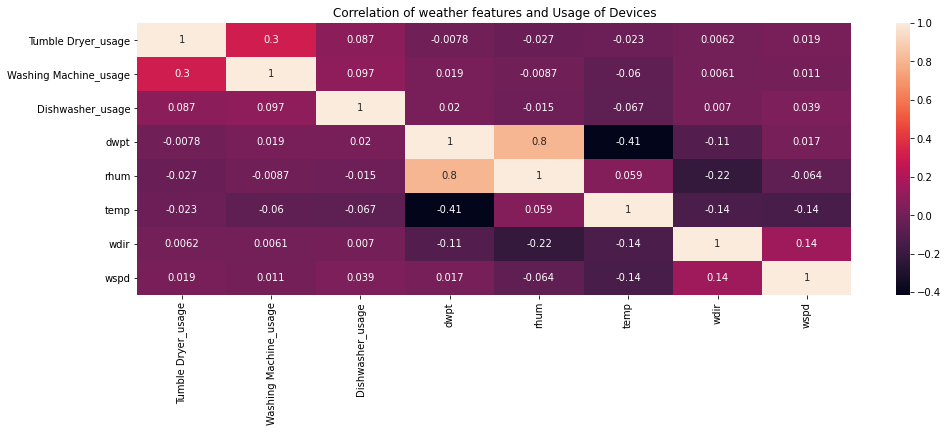

In [5]:
# preparation of data
truncation_params = {
    'features': 'all',
    'factor': 1.5,
    'verbose': 1
}

scale_params = {
    'features': 'all',
    'kind': 'MinMax',
    'verbose': 1
}

aggregate_params = {
    'resample_param': '60T'
}

shiftable_devices = ['Tumble Dryer', 'Washing Machine', 'Dishwasher'] # computer und tv sind m. E. non-shiftable, VR

device_params = {
    'threshold': 0.15
}

load_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'aggregate': aggregate_params,
    'shiftable_devices': shiftable_devices,
    'device': device_params
}

# Load household and preprocess
household_id = 3
household = helper.load_household(DATA_PATH, household_id, weather_sel=True)

In [ ]:
output, scaled, df = Preparation_Agent(household).pipeline_load(household, load_pipe_params)

The following correlation plot displays a positive correlation between the usage of the washing machine and the tumble dryer, which was expected, as if you use the washing machine and own a tumble dryer one would usually use it afterwards. Furthermore there seem to be strong positive correlation between the relative humidity (rhum) and the dew point (dwpt) and a strong negative correlation between the air temeprature (temp) and the dew point (dwpt).
n general, it can be said that the data are positively correlated with each other, but there are no strong interdependencies.


In [24]:
plt.title('Correlation of weather features and Usage of Devices')
weather_df = df[['Tumble Dryer_usage', 'Washing Machine_usage', 'Dishwasher_usage','dwpt', 'rhum', 'temp', 'wdir', 'wspd']]
sns.heatmap(weather_df.corr(), annot=True)

,Washing Machine_usage
count,330.000000
mean,2.357576
std,1.499550
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,9.000000


Now we want to examine if a device was used multiple times each day. As for the tumble dryer there exist dates were it was used 8 times, the washing machine was used 9 times a day and the dishwasher was used 7 times a day as a max, which is rather rare but interesting for our recommendation system when it comes to saving energy and money.

In [ ]:
# Tumble Dryer in use
reIndexed = df.reset_index()
reIndexed['Date'], reIndexed['clock'] = reIndexed['Time'].apply(lambda x: x.date()), reIndexed['Time'].apply(lambda x: x.time())
wm = reIndexed['Washing Machine_usage']==1
td = reIndexed['Tumble Dryer_usage']==1
dw = reIndexed['Dishwasher_usage'] ==1
td_inuse = reIndexed[td]
td_inuse.groupby('Date')[['Tumble Dryer_usage']].count().describe()

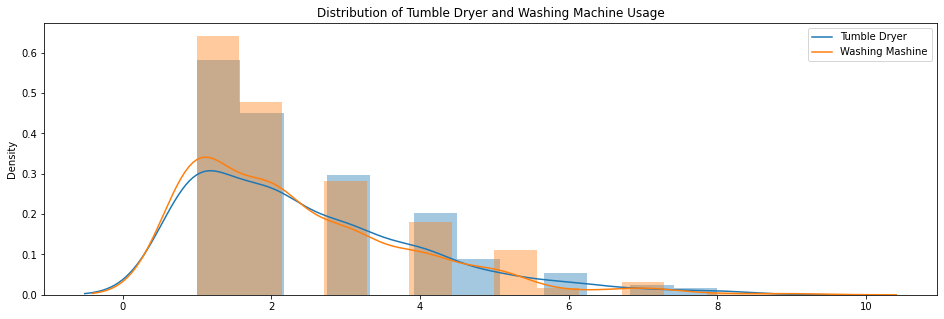

In [59]:
# Washing Machine in use
wm_inuse = reIndexed[wm]
wm_inuse.groupby('Date')[['Washing Machine_usage']].count().describe()

<AxesSubplot:title={'center':'Distribution of Dishwasher Usage'}, ylabel='Density'>

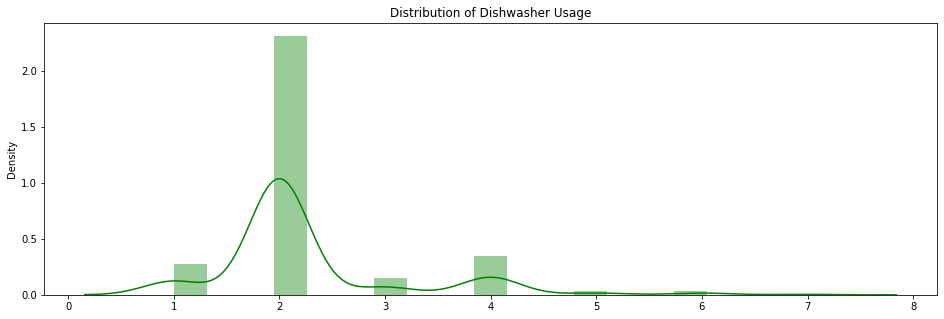

In [41]:
# Dishwasher in use
dw_inuse = reIndexed[dw]
dw_inuse.groupby('Date')[['Dishwasher_usage']].count().describe()

All devices show a mean around two, so on average each device is used two times a day.
As expected the following distplot shows a similiar distribution of the usage of the washing machine and the tumble dryer.

In [49]:
plt.title('Distribution of Tumble Dryer and Washing Machine Usage')
sns.distplot(td_inuse['Date'].value_counts().values)
sns.distplot(wm_inuse['Date'].value_counts().values)
plt.legend(labels=['Tumble Dryer', 'Washing Mashine'])

In [ ]:
plt.title('Distribution of Dishwasher Usage')
sns.distplot(dw_inuse['Date'].value_counts().values, color='green')

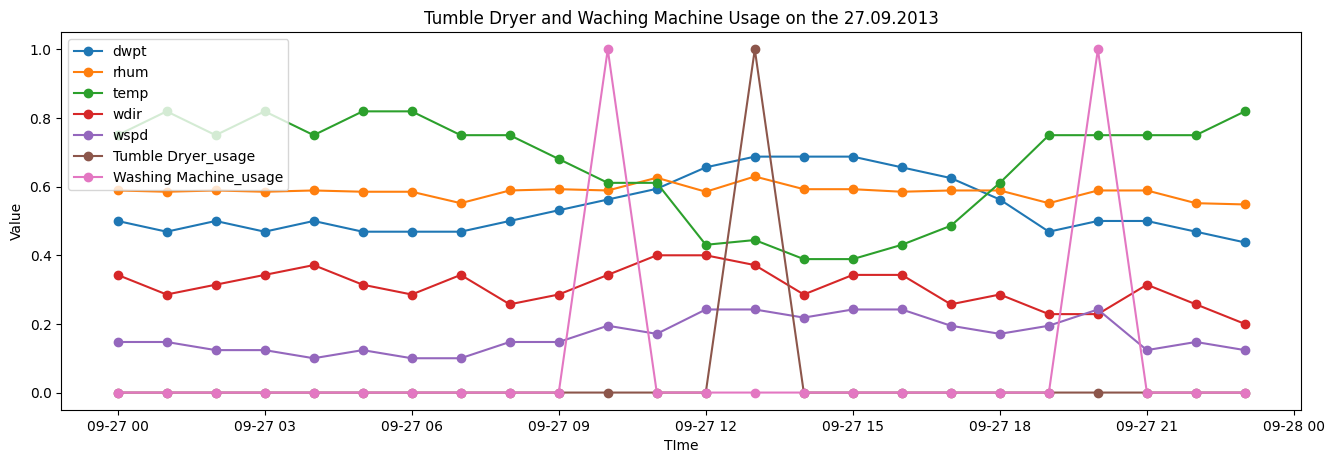

In [29]:
# Look at dates of interest for Tumble dryer and Washing Machine
df_20_04_2014 = df[['dwpt','rhum','temp','wdir','wspd','Tumble Dryer_usage', 'Washing Machine_usage']].filter(like='2014-04-20', axis=0)
df_10_08_2014 = df[['dwpt','rhum','temp','wdir','wspd','Tumble Dryer_usage', 'Washing Machine_usage']].filter(like='2014-08-10', axis=0)
df_03_09_2015 = df[['dwpt','rhum','temp','wdir','wspd','Tumble Dryer_usage', 'Washing Machine_usage']].filter(like='2015-09-03', axis=0)
df_26_06_2014 = df[['dwpt','rhum','temp','wdir','wspd','Tumble Dryer_usage', 'Washing Machine_usage']].filter(like='2014-06-26', axis=0)
df_28_09_2013 = df[['dwpt','rhum','temp','wdir','wspd', 'Tumble Dryer_usage', 'Washing Machine_usage']].filter(like='2013-09-28', axis=0)

In [ ]:
# Look at dates of interest for Dishwasher
df_27_09_2013 = df[['dwpt','rhum','temp','wdir','wspd','Dishwasher_usage']].filter(like='2013-09-27', axis=0)
df_25_11_2014 = df[['dwpt','rhum','temp','wdir','wspd' ,'Dishwasher_usage']].filter(like='2014-11-25', axis=0)
df_19_10_2014 = df[['dwpt','rhum','temp','wdir','wspd', 'Dishwasher_usage']].filter(like='2014-10-19', axis=0)
df_01_07_2014 = df[['dwpt','rhum','temp','wdir','wspd', 'Dishwasher_usage']].filter(like='2014-07-01', axis=0)

In the following, we will examine the courses of the weather features and the use of the different household devices in order to detect any relations between those properties.
Especially those dates were each device is used multiple times are of great interest.
When it comes to the usage of the washing machine and tumble dryer, the course of the graphs confirms once again that the dryer is mostly used after the washing machine. Almost everytime those devices are used there seem to be a drop in the weather features, which indicates that those features would be helpful for our recommender system.

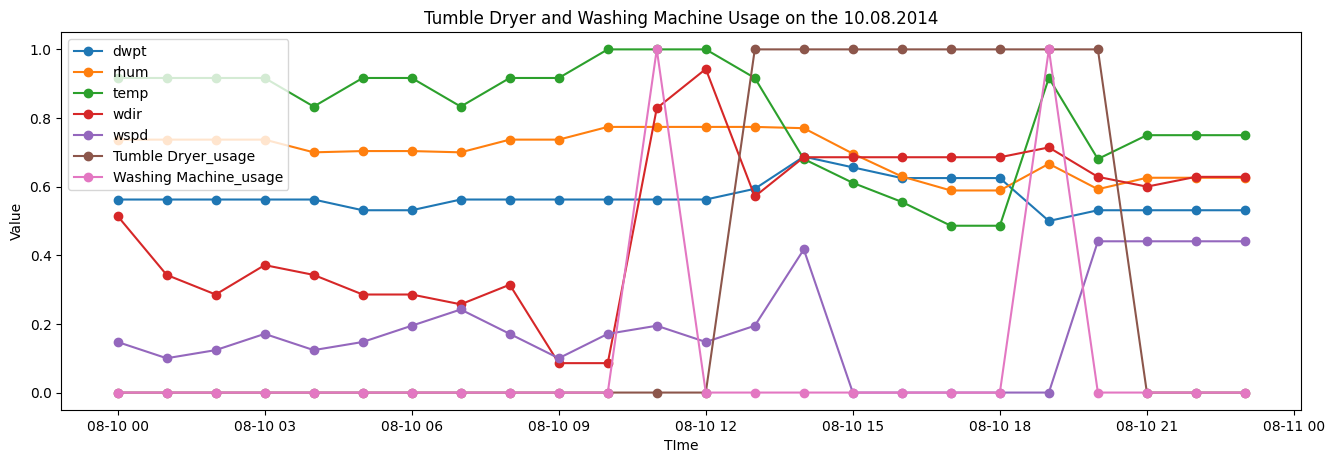

In [31]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='TIme', ylabel='Value', dpi=100, axvspan=True):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, marker='o')
    plt.legend(df_27_09_2013.columns.tolist())

    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df_27_09_2013, x=df_27_09_2013.index, y=df_27_09_2013.values, title='Tumble Dryer and Waching Machine Usage on the 27.09.2013')


On the days were each device was used multiple times like the 28.09.2013 or the 10.08.2014 were the tumble dryer was used 8 times a day it is important to note that it seemed to be running for 8 hours. In order to get a more precise insight into the user behavior at such special events, it would be useful to enrich our data with exact start and end times for each dryer cycle.

In [ ]:
plot_df(df_28_09_2013, x=df_28_09_2013.index, y=df_28_09_2013.values, title='Tumble Dryer and Washing Machine Usage on the 28.09.2013')

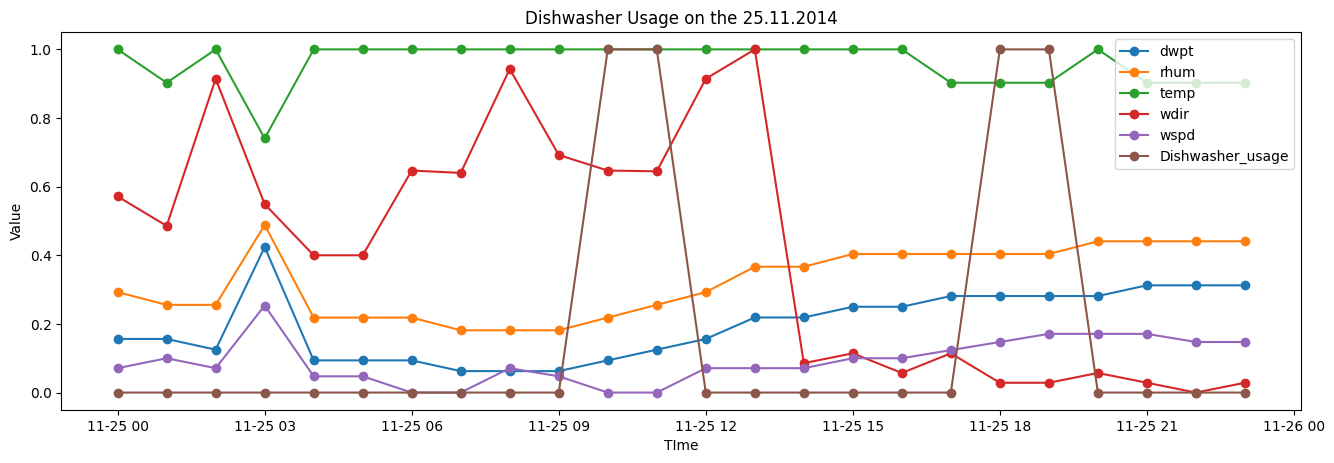

In [52]:
plot_df(df_10_08_2014, x=df_10_08_2014.index, y=df_10_08_2014.values, title='Tumble Dryer and Washing Machine Usage on the 10.08.2014')

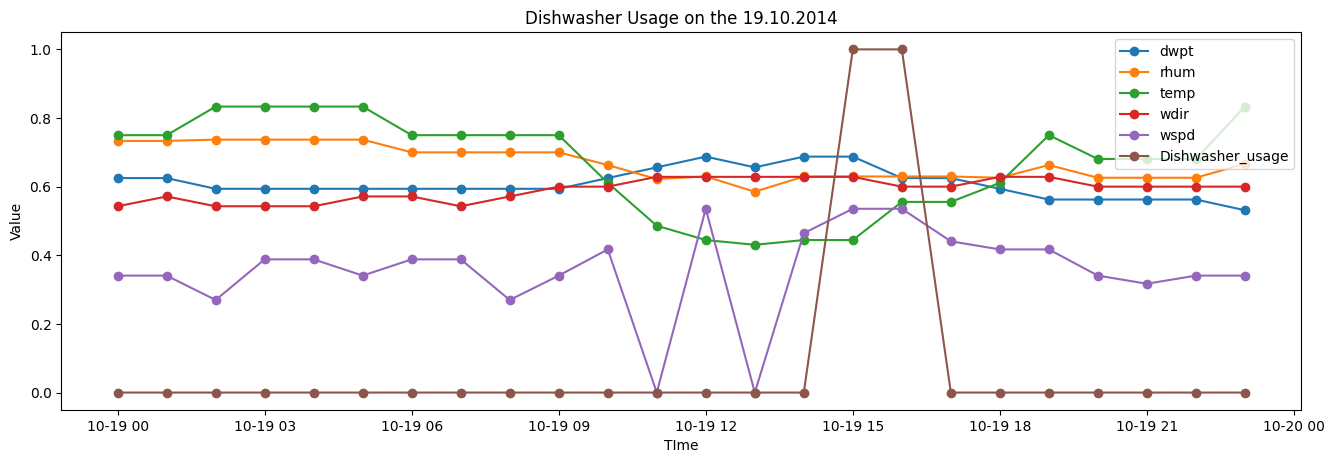

In [54]:
plot_df(df_26_06_2014, x=df_26_06_2014.index, y=df_26_06_2014.values, title='Tumble Dryer and Washing Machine Usage on the 26.06.2014')

When it comes to the course of dishwasher use and weather data, no strong correlations can be found.

In [ ]:
plot_df(df_25_11_2014, x=df_25_11_2014.index, y=df_25_11_2014.values, title='Dishwasher Usage on the 25.11.2014')

In [ ]:
plot_df(df_19_10_2014, x=df_19_10_2014.index, y=df_19_10_2014.values, title='Dishwasher Usage on the 19.10.2014')

In [ ]:
plot_df(df_01_07_2014, x=df_01_07_2014.index, y=df_01_07_2014.values, title='Dishwasher Usage on the 01.07.2014')

In general, the relationship between the weather features and the usage of the devices of a household are worth investigating and will be further pursued when it comes to improving our Multi-Agent.

### 4.2 Evaluation <a name="Eval"></a>

to do: Einleitungstext

#### 4.2.1 Performance <a name="Eval_Performance"></a>

AUC, MSE (load?) -->  paper Riabchuk

#### 4.2.2 Explainability <a name="Eval_Explainability"></a>

When it comes to our evaluation of the explainability approaches we want to quantitatively compare the
individual explanations that the models offer. The literature does not propose one clear framework which metrics to use as it is also highly application dependent.
Nevertheless, we will use the following concepts that are widely applied to determine how well
 the explainability approaches work in giving accurate local explanations (Carvalho et. al, 2019):

**Accuracy** Similar to predictive accuracy, the accuracy of the explanation method refers to how well the explainable model
predicts unseen instances compared to the real outcome. We will also use the Are Under the ROC-Curve (AUC) as a measure to compare the true labels with the predictions from the explainers.

**Fidelity** This criterion determines how close the prediction from the explainable model is to the black-box model's prediction.
Therefore, fidelity describes how well the explainability model can imitate the prediction of the black-box model.
We use the measure AUC again but replace the target label with the predictions from the black-box model.
Note that Carvalho et. al (2019) mention an interrelation between these two concepts: black-box models with high predictive
accuracy and explanations that offer a high fidelity are also highly accurate when it comes to real predictions. This is
the ideal that we would like to achieve.

Additionally, we calculate the *Mean-Squared-Explainability Error* (MSEE) for every approach to measure not only if
the decision of the black-box model and the explainability approach is the same but also to measure how close they are to each other.
This metric represents how well the explainability approaches are calibrated. The formula of the traditionally used
Mean-Squared-Error is adapted in the following way: (citation? kann gerade iwie keine finden...)

$$ MSEE_{} = \frac{1}{n} (y_{pred} - y_{expl})^2 $$

**Efficiency (Algorithmic complexity)** Lastly, we evaluate how efficient the explainability approaches are in calculating
the local explanations. To the end, we measure the time that each method needs to calculate all the
local explanations for a day and average the values for all calculations (Carvalho et. al, 2019).

To do:  wie explainability eval in code (input, output, arbeitsweise)


## 5. Results <a name="Results"></a>

to do: einleitung

### 5.1 Performance <a name="Results_Performance"></a>
include:
- grid search
- wetter verbesserung
- model vergleich: mit auc

### 5.2 Explainability <a name="Results_explainability"></a>

Idee: ROC Curve with Accuracy and Fidelity


### 5.3 Final Recommendation <a name="Final_rec"></a>
Note:  Carvalho et. al (2019) mention criteria for Human-friendly explanations that we could include here for reasoning
our final explanation approach


In [ ]:
######################### OURSORCING?
threshold = 0.01  ##################### WARUM?
active_appliances = ['Toaster', 'Tumble Dryer', 'Dishwasher', 'Washing Machine','Television', 'Microwave', 'Kettle']

activity_params = {
    'active_appliances': active_appliances,
    'threshold': threshold
}

time_params = {
    'features': ['hour', 'day_name']
}

activity_lag_params = {
    'features': ['activity'],
    'lags': [24, 48, 72]
}

activity_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'aggregate': aggregate_params,
    'activity': activity_params,
    'time': time_params,
    'activity_lag': activity_lag_params
}

#load agent
device_params = {
    'threshold': threshold ################## THRESHOLD IST BEI JANAS EDA 0.15, hier 0,01
}

#usage agent
device = {
    'threshold' : threshold}

aggregate_params24_H = {
    'resample_param': '24H'
}

usage_pipe_params = {
    'truncate': truncation_params,
    'scale': scale_params,
    'activity': activity_params,
    'aggregate_hour': aggregate_params,
    'aggregate_day': aggregate_params24_H,
    'time': time_params,
    'activity_lag': activity_lag_params,
    'shiftable_devices' : shiftable_devices,
    'device': device
}

In [ ]:
# calling the preparation pipeline
#prep = Preparation_Agent(household)
#activity_df = prep.pipeline_activity(household, activity_pipe_params)
#load_df, _, _ = prep.pipeline_load(household, load_pipe_params)
#usage_df = prep.pipeline_usage(household, usage_pipe_params)

# load price data
# FILE_PATH = '/content/drive/MyDrive/T4_Recommendation-system-for-demand-response-and-load-shifting/02_data/'
#price_df = helper.create_day_ahead_prices_df(DATA_PATH, 'Day-ahead Prices_201501010000-201601010000.csv')


In [ ]:
#activity_df.to_pickle('../data/processed_pickle/activity_df.pkl')
#load_df,_, _ .to_pickle('../data/processed_pickle/load_df.pkl')
#usage_df.to_pickle('../data/processed_pickle/usage_df.pkl')
#price_df.to_pickle('../data/processed_pickle/price_df.pkl')

In [ ]:
# Load pickle data
activity_df = pd.read_pickle('../data/processed_pickle/activity_df.pkl')
load_df = pd.read_pickle('../data/processed_pickle/load_df.pkl')
usage_df = pd.read_pickle('../data/processed_pickle/usage_df.pkl')
price_df = pd.read_pickle('../data/processed_pickle/price_df.pkl')

In [ ]:
recommend = X_Recommendation_Agent(activity_df, usage_df, load_df, price_df, shiftable_devices, model_type='random forest')
price = recommend.electricity_prices_from_start_time("2014-08-21")
table= recommend.pipeline(date = "2014-08-21", activity_prob_threshold = 0.4,  usage_prob_threshold = 0.3, evaluation=False, weather_sel=False)
table
#recommend.visualize_recommendation_by_device(recommendation_by_decvice_dict)

In [ ]:
recommend.visualize_recommendation(table, price, diagnostics=False)

In [ ]:
recommend.visualize_recommendation(table, price, diagnostics=True)


## 6. Discussion <a name="Discussion"></a>

### 6.1 Contributions <a name="Contributions"></a>


### 6.2 Limitations <a name="Limitations"></a>


So many different approaches. Available Github Repos but dependencies cause several conflicts due to different package versions.
Missing user data. To evaluate the explainability approach from a human perspektive ot would be of cruical importance to measure users trust and acceptance 


Fidelity is only assesed in terms of accuracy but fidelity is more than that. Potentially, clarity and completeness of fidelity should also be assesed (Zhou et al., 2021).

No evaluaation of **Interpretability/ Comprehensibility/ Understandability**; not with proxies because not useful (?) in our case but to evaluate the usefulness of our explantion should be next stept. This critera deals with how well humans actually
 understand the explanations. Since we have decided on functionally-grounded evaluations
we would have to rely on proxies like amount of features/ model size / ...  as a proxy which is not really useful since we can determine that ourselves.

https://interpretable-ml-class.github.io/ see evaluation of xai papers --> hints at experiments

### 6.3 Implications <a name="Implications"></a>

### 6.4 Future Research  <a name="Future"></a>

There are a number of gaps in our knowledge around explainbale AI in research that follow from our findings, especially for Recommender Systems in a Smart Home Environment. The topic would benefit from further research, including realist evaluation to extend and further test the theory we have developed here:

1.  Expand the data basis with addtional information about the user and the human-recommender system interaction and apply generalized             additive model with manifest and latent interactions (GAMMLI) introdcued by Guo et. al. (2020). This model is intrinsically interpretable,     additively consists of the user and item main effects, the manifest user-item interactions based on observed features, and the latent          interaction effects from residuals. Unlike conventional collaborative filtering methods, the group effect of users and items are               considered in GAMMLI. It is ben- eficial for enhancing the model interpretability, and can also facilitate the cold-start recommendation       problem. 


2.  Try out Neural Networks to detect certain patterns in user behavior. 
    In order to tackle the lack of interpretability which is an inevitable problem when using neural network models in real applications Yang      et al. (2021) introduced an explainable neural network based on generalized additive models with structured interactions (GAMI-Net). It is     proposed to pursue a good balance between prediction accuracy and model interpretability. GAMI- Net is a disentangled feedforward network      with multiple additive subnetworks where each subnetwork consists of multiple hidden layers and is designed for capturing one main effect      or one pairwise interaction.


3.  Expand the Recommender System to provide the user with nseveral recommendations per day to model the reality more truthfully.


Other metrics see table 2 under attribution- based explanations (Zhou et al., 2021).

paper: 'Human-in-the-Loop Interpretability Prior'
paper: https://dl.acm.org/doi/abs/10.1145/3351095.3375624

## 7. Conclusion  <a name="Conclusion"></a>

to do: conlusion adden


## References

1. Nori, H., Jenkins, S., Koch, P., & Caruana, R. (2019). Interpretml: A unified framework for machine learning interpretability. arXiv preprint arXiv:1909.09223.

2. Cunningham, P., & Delany, S. J. (2020). k-Nearest neighbour classifiers: (with Python examples). arXiv preprint arXiv:2004.04523.

3. Chen, T., & Guestrin, C. (2016, August). Xgboost: A scalable tree boosting system. In Proceedings of the 22nd acm sigkdd international conference on knowledge discovery and data mining (pp. 785-794).

4. Breiman, Leo. (2001). Machine Learning, Volume 45, Number 1 - SpringerLink. Machine Learning. 45. 5-32. 10.1023/A:1010933404324.

5. Freund, Y., & Schapire, R. E. (1997). A decision-theoretic generalization of on-line learning and an application to boosting. Journal of computer and system sciences, 55(1), 119-139.

6. Chen, T. (2016). Guestrin, C.: XGBoost: A Scalable Tree Boosting System. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD’16) (pp. 785-794).

7. Peng, C. Y. J. (2002). An introduction to logistic regression analysis and reporting 96 j. Educ. Res, 3(10).

8. Singh, Sengupta, Lakshminarayanan. (2020). Explainable Deep Learning Models in Medical Image Analysis. Journal of Imaging 6, 52.

9. Ribeiro, Singh, Guestrin. (2016). "Why should I trust you?" Explaining the predictions of any classifier. In Proceedings of the 22nd ACM SIGKDD international conference on knowledge discovery and data mining. 1135–1144.

10. Lundberg, S. M., & Lee, S. I. (2017, December). A unified approach to interpreting model predictions. In Proceedings of the 31st international conference on neural information processing systems (pp. 4768-4777).

11. Lundberg, S. M., Erion, G., Chen, H., DeGrave, A., Prutkin, J. M., Nair, B., ... & Lee, S. I. (2020). From local explanations to global understanding with explainable AI for trees. Nature machine intelligence, 2(1), 56-67.

12. Molnar, C. (2021). Interpretable machine learning. https://christophm.github.io/interpretable-ml-book/

13. Zhou, J., Gandomi, A. H., Chen, F., & Holzinger, A. (2021). Evaluating the quality of machine learning explanations: A survey on methods and metrics. Electronics, 10(5), 593.

14. Robnik-Šikonja, M., & Bohanec, M. (2018). Perturbation-based explanations of prediction models. In Human and machine learning (pp. 159-175). Springer, Cham.

15. Carvalho, D. V., Pereira, E. M., & Cardoso, J. S. (2019). Machine learning interpretability: A survey on methods and metrics. Electronics, 8(8), 832.

16. Guo, Y., Su, Y., Yang, Z., & Zhang, A. (2020). Explainable Recommendation Systems by Generalized Additive Models with Manifest and Latent Interactions. arXiv preprint arXiv:2012.08196.

17. Yang, Z., Zhang, A., & Sudjianto, A. (2021). GAMI-Net: An explainable neural network based on generalized additive models with structured interactions. Pattern Recognition, 120, 108192.

Alsalemi, A., Sardianos, C., Bensaali, F., Varlamis, I., Amira, A., & Dimitrakopoulos, G. (2019). The role of micro-moments: A survey of habitual behavior change and recommender systems for energy saving. IEEE Systems Journal, 13(3), 3376-3387.

Economidou, M., Todeschi, V., Bertoldi, P., Agostino, D. D., Zangheri, P., & Castellazzi, L. (2020). Review of 50 years of EU energy efficiency policies for buildings. Energy and Buildings, 110322.

Fraternali, P., Herrera, S., Novak, J., Melenhorst, M., Tzovaras, D., Krinidis, S., ... & Cellina, F. (2017, June). enCOMPASS—An integrative approach to behavioural change for energy saving. In 2017 Global Internet of Things Summit (GIoTS) (pp. 1-6). IEEE.

Himeur, Y., Alsalemi, A., Al-Kababji, A., Bensaali, F., Amira, A., Sardianos, C., ... & Varlamis, I. (2021). A survey of recommender systems for energy efficiency in buildings: Principles, challenges and prospects. Information Fusion, 72, 1-21.

Riabchuk et al. (forthcoming) Utility-based context-aware multi-agent recommendation system for energy efficiency in residential buildings. Preprint.

Zhang, Y., & Chen, X. (2020). Explainable recommendation: A survey and new perspectives. Foundations and Trends in Information Retrieval, 14(1), 1-101.


Bodria, F., Giannotti, F., Guidotti, R., Naretto, F., Pedreschi, D., & Rinzivillo, S. (2021). Benchmarking and survey of explanation methods for black box models. arXiv preprint arXiv:2102.13076.
Alvarez-Melis, D., & Jaakkola, T. S. (2018). On the robustness of interpretability methods. arXiv preprint arXiv:1806.08049.

Zafar, M. R., & Khan, N. M. (2019). DLIME: A deterministic local interpretable model-agnostic explanations approach for computer-aided diagnosis systems. arXiv preprint arXiv:1906.10263.